# Social Media Crisis Analysis

In [1]:
## Import Libraries
import pandas as pd
import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
# Uncomment if nltk resources are not already downloaded
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
## Function to Extract Video ID from URL
def extract_video_id(url):
    if 'watch?v=' in url:
        return url.split('watch?v=')[-1]
    elif 'shorts/' in url:
        return url.split('shorts/')[-1]
    else:
        return None

In [3]:
## Function to Fetch Comments using YouTube API
def get_youtube_comments(video_url, api_key):
    video_id = extract_video_id(video_url)
    if not video_id:
        print(f"Invalid URL: {video_url}")
        return []

    comments = []
    url = f"https://www.googleapis.com/youtube/v3/commentThreads?key={api_key}&textFormat=plainText&part=snippet&videoId={video_id}&maxResults=100"

    while url:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Error: Unable to fetch comments for video {video_url}")
            break

        data = response.json()
        for item in data.get('items', []):
            comments.append(item['snippet']['topLevelComment']['snippet']['textDisplay'])

        # Get the next page token
        url = f"{url}&pageToken={data.get('nextPageToken')}" if 'nextPageToken' in data else None

    return comments

In [ ]:
## Fetch Comments from Multiple Videos
# List of video URLs
video_urls = [
    "https://www.youtube.com/watch?v=tfxdvXPzVLQ",  # Video 1
    "https://www.youtube.com/shorts/IBiWJfw-fgc",   # Video 2 (Shorts)
    "https://www.youtube.com/watch?v=eqHIbP0GR6I",  # Video 3
    "https://www.youtube.com/watch?v=K9Uf3eUWKE8"   # Video 4
]

api_key = "Insert API KEY in Here"

In [5]:
# Fetch comments for all videos
all_comments = []
for video_url in video_urls:
    try:
        comments = get_youtube_comments(video_url, api_key)
        all_comments.extend(comments)
    except Exception as e:
        print(f"Error fetching comments for video {video_url}: {e}")

# Creating a DataFrame
data = pd.DataFrame({'comment': all_comments})

In [6]:
data

,comment
0,Kendari itu apa ya...?.. dimana itu ...?\nKok ...
1,harus di bakar semua gerai mcd di indonesia...
2,Mendingan itu daripada roket chicken di lamong...
3,Cuma mengigatkan pendapatan aku sih ya bolehsi...
4,Badan Nakotika Nasional. Yayasan Penuai Indone...
...,...
7465,All McDonald's is haram now! Never again eatin...
7466,Keep up the good work amazing!
7467,Despite salaries increasing
7468,They had salaries increased this year


In [7]:
## Preprocessing Comments
# Function for preprocessing
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Preprocessing comments
data['processed_comment'] = data['comment'].apply(preprocess_text)

## Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(data['processed_comment'])

In [8]:
data

,comment,processed_comment
0,Kendari itu apa ya...?.. dimana itu ...?\nKok ...,kendari itu apa ya dimana itu kok baru dengar ...
1,harus di bakar semua gerai mcd di indonesia...,haru di bakar semua gerai mcd di indonesia
2,Mendingan itu daripada roket chicken di lamong...,mendingan itu daripada roket chicken di lamong...
3,Cuma mengigatkan pendapatan aku sih ya bolehsi...,cuma mengigatkan pendapatan aku sih ya bolehsi...
4,Badan Nakotika Nasional. Yayasan Penuai Indone...,badan nakotika nasion yayasan penuai indonesia...
...,...,...
7465,All McDonald's is haram now! Never again eatin...,mcdonald haram never eat
7466,Keep up the good work amazing!,keep good work amaz
7467,Despite salaries increasing,despit salari increas
7468,They had salaries increased this year,salari increas year


In [9]:
## Applying K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
data

,comment,processed_comment,cluster
0,Kendari itu apa ya...?.. dimana itu ...?\nKok ...,kendari itu apa ya dimana itu kok baru dengar ...,1
1,harus di bakar semua gerai mcd di indonesia...,haru di bakar semua gerai mcd di indonesia,1
2,Mendingan itu daripada roket chicken di lamong...,mendingan itu daripada roket chicken di lamong...,1
3,Cuma mengigatkan pendapatan aku sih ya bolehsi...,cuma mengigatkan pendapatan aku sih ya bolehsi...,1
4,Badan Nakotika Nasional. Yayasan Penuai Indone...,badan nakotika nasion yayasan penuai indonesia...,1
...,...,...,...
7465,All McDonald's is haram now! Never again eatin...,mcdonald haram never eat,4
7466,Keep up the good work amazing!,keep good work amaz,1
7467,Despite salaries increasing,despit salari increas,1
7468,They had salaries increased this year,salari increas year,1


In [11]:
## Sentiment Analysis using TextBlob
def get_sentiment(comment):
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [12]:
# Apply sentiment analysis
data['sentiment'] = data['comment'].apply(get_sentiment)

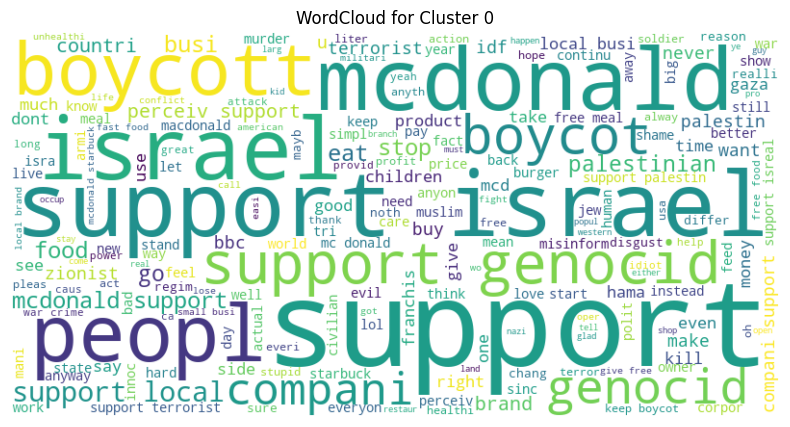

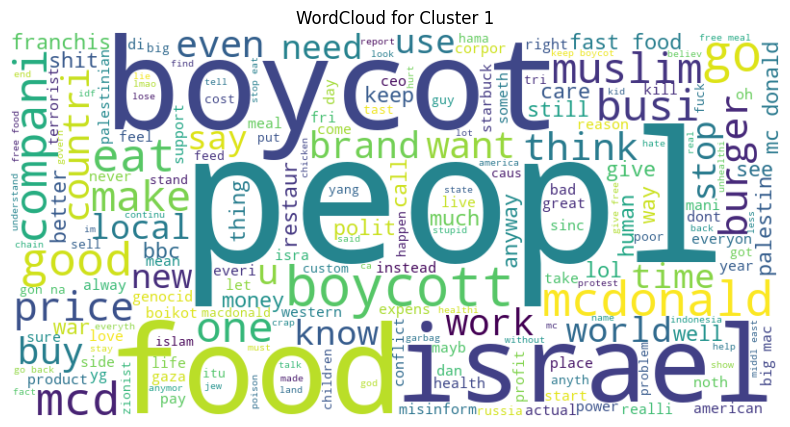

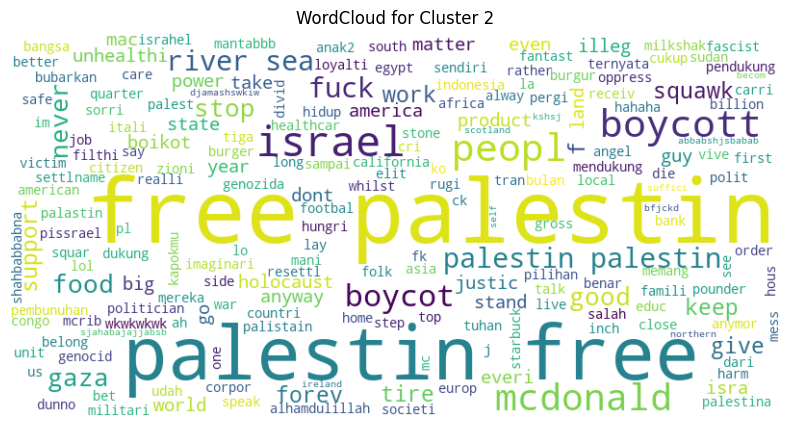

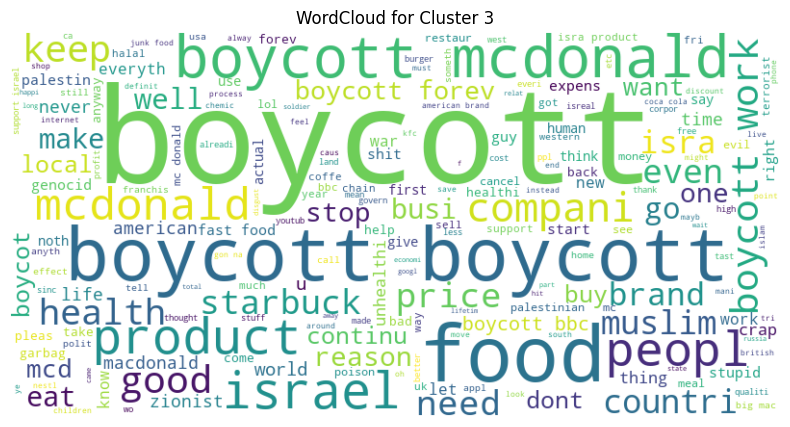

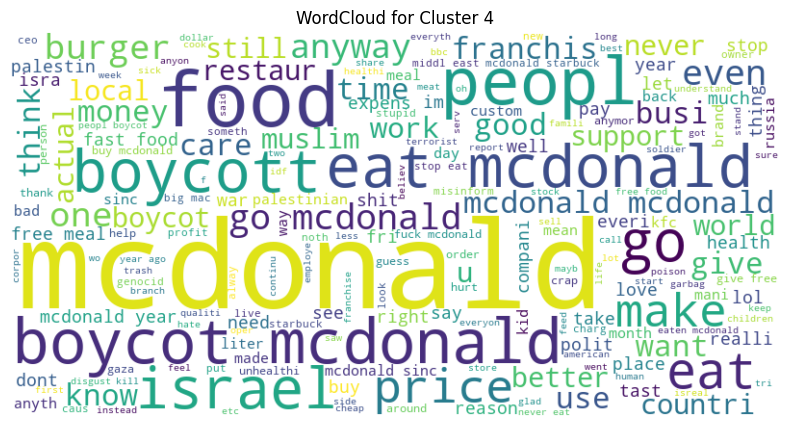

In [13]:
## Generate WordClouds for Each Cluster
for cluster in range(num_clusters):
    cluster_comments = data[data['cluster'] == cluster]['processed_comment']
    cluster_text = ' '.join(cluster_comments)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster}')
    plt.show()

C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\529585278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['sentiment'], palette='coolwarm')


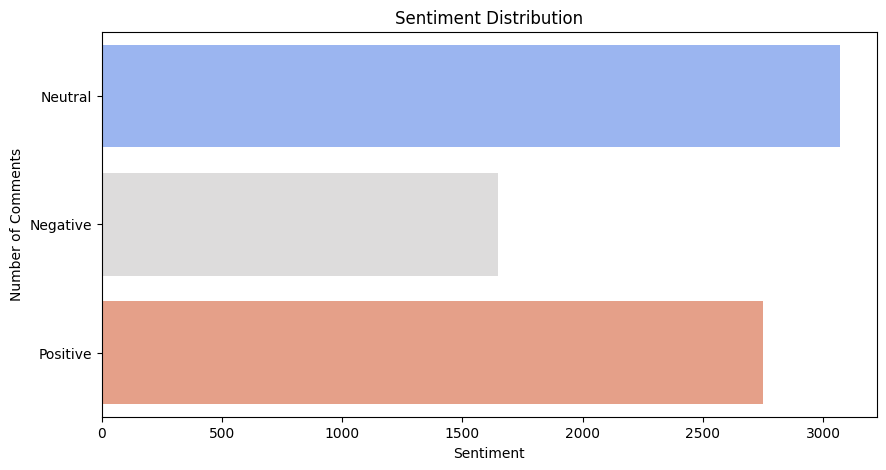

In [14]:
## Visualizing Sentiment Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data['sentiment'], palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

In [15]:
# Menampilkan hanya kolom 'processed_comment' dan 'sentiment'
selected_columns = data[['processed_comment', 'sentiment']]
selected_columns

,processed_comment,sentiment
0,kendari itu apa ya dimana itu kok baru dengar ...,Neutral
1,haru di bakar semua gerai mcd di indonesia,Neutral
2,mendingan itu daripada roket chicken di lamong...,Negative
3,cuma mengigatkan pendapatan aku sih ya bolehsi...,Neutral
4,badan nakotika nasion yayasan penuai indonesia...,Neutral
...,...,...
7465,mcdonald haram never eat,Neutral
7466,keep good work amaz,Positive
7467,despit salari increas,Neutral
7468,salari increas year,Neutral


C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\2829612572.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis")


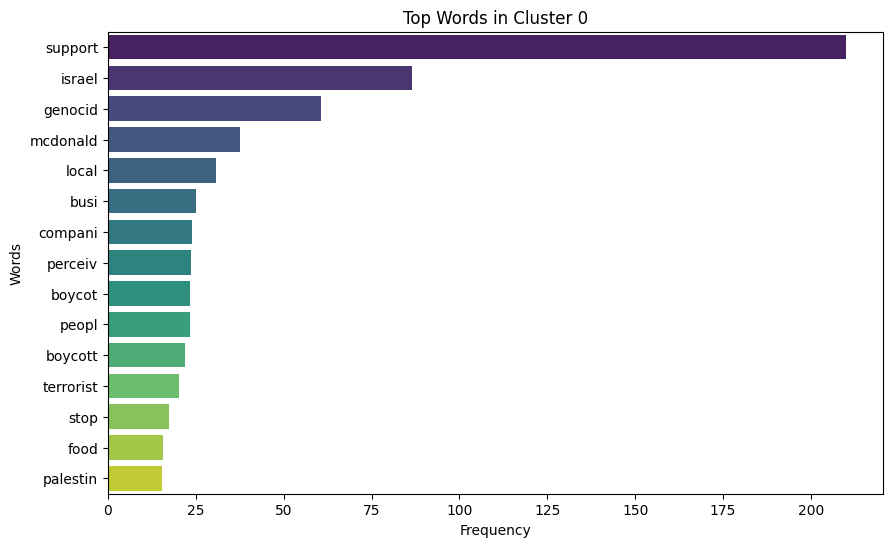

C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\2829612572.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis")


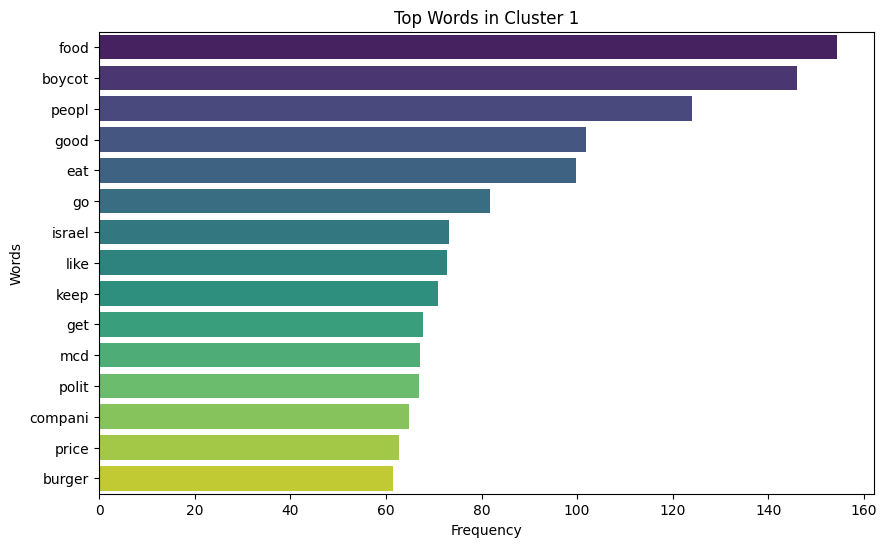

C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\2829612572.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis")


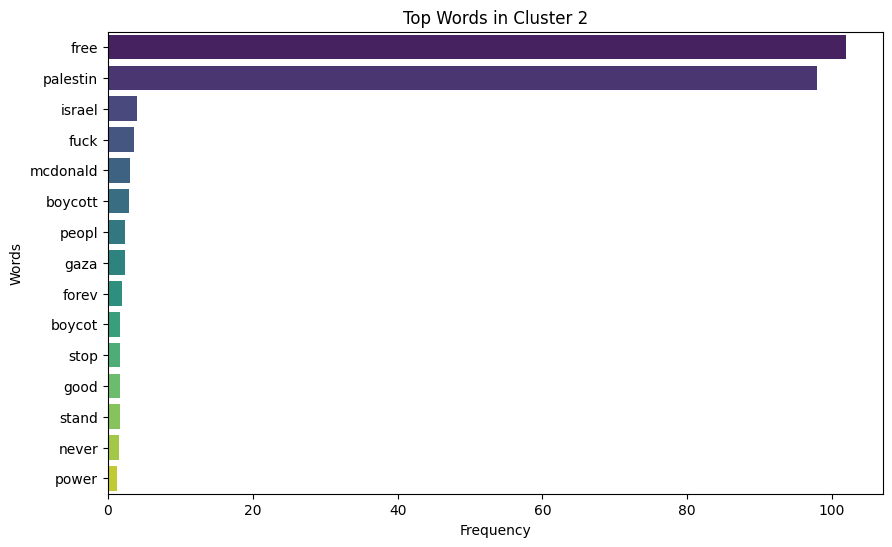

C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\2829612572.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis")


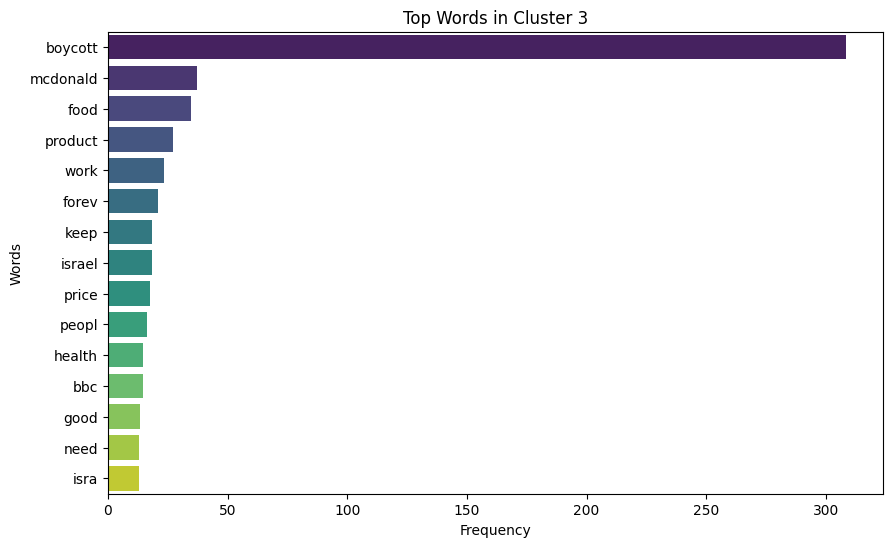

C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\2829612572.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis")


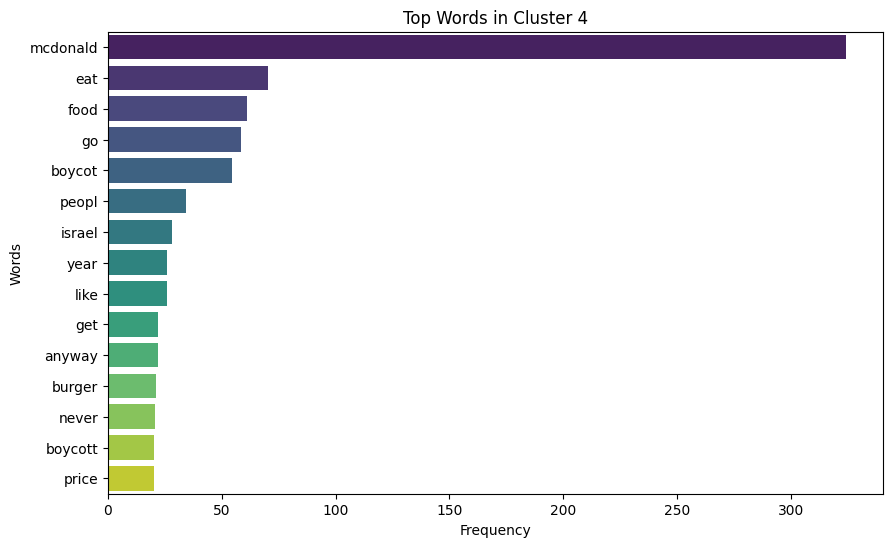

In [16]:
## Menghitung Frekuensi Kata Per Cluster
cluster_word_freq = {}
for cluster in range(num_clusters):
    cluster_comments = data[data['cluster'] == cluster]['processed_comment']
    vectorized_cluster = vectorizer.transform(cluster_comments)
    word_freq = vectorized_cluster.toarray().sum(axis=0)
    cluster_word_freq[cluster] = dict(zip(vectorizer.get_feature_names_out(), word_freq))

## Visualisasi Frekuensi Kata dalam Grafik Bar Chart
for cluster, freq_dict in cluster_word_freq.items():
    # Sort words by frequency
    sorted_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:15]
    words, freqs = zip(*sorted_words)
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(freqs), y=list(words), palette="viridis")
    plt.title(f'Top Words in Cluster {cluster}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

Confusion Matrix:
 [[ 329 1308   12]
 [ 521 2080  150]
 [ 672 2385   13]]

Accuracy: 0.32
Precision: 0.22
Recall: 0.32
F1-Score: 0.23


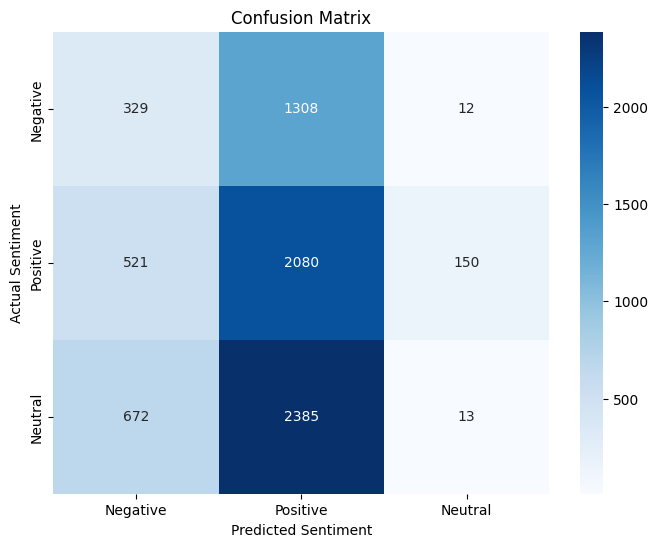

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Mapping sentiments to numeric values (Positive=1, Negative=0, Neutral=2)
data['sentiment_numeric'] = data['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})

# Simulasi hasil prediksi (gunakan cluster sebagai prediksi sementara)
data['predicted_sentiment'] = data['cluster'] % 3  # Contoh memetakan cluster ke 3 kategori sentimen

# Menghitung confusion matrix
cm = confusion_matrix(data['sentiment_numeric'], data['predicted_sentiment'], labels=[0, 1, 2])

# Menghitung metrik
accuracy = accuracy_score(data['sentiment_numeric'], data['predicted_sentiment'])
precision = precision_score(data['sentiment_numeric'], data['predicted_sentiment'], average='macro')
recall = recall_score(data['sentiment_numeric'], data['predicted_sentiment'], average='macro')
f1 = f1_score(data['sentiment_numeric'], data['predicted_sentiment'], average='macro')

# Tampilkan confusion matrix dan metrik
print("Confusion Matrix:\n", cm)
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()


In [18]:
## Membuat Tabel untuk Hasil WordCloud
wordcloud_tables = {}

for cluster, freq_dict in cluster_word_freq.items():
    # Sort words by frequency
    sorted_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Convert to DataFrame
    wordcloud_table = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])
    wordcloud_tables[cluster] = wordcloud_table

    # Display the table
    print(f"\nTop Words in Cluster {cluster}")
    display(wordcloud_table.head(15))  # Show top 15 words



Top Words in Cluster 0


,Word,Frequency
0,support,209.963304
1,israel,86.473293
2,genocid,60.585794
3,mcdonald,37.616651
4,local,30.710990
5,busi,25.070258
6,compani,23.827247
7,perceiv,23.778240
8,boycot,23.372974
9,peopl,23.230010



Top Words in Cluster 1


,Word,Frequency
0,food,154.383617
1,boycot,146.074105
2,peopl,124.091690
3,good,101.894880
4,eat,99.845962
5,go,81.763615
6,israel,73.251996
7,like,72.706871
8,keep,70.811629
9,get,67.763443



Top Words in Cluster 2


,Word,Frequency
0,free,101.915941
1,palestin,97.902299
2,israel,4.015556
3,fuck,3.660226
4,mcdonald,3.071114
5,boycott,2.932855
6,peopl,2.400716
7,gaza,2.374196
8,forev,1.949112
9,boycot,1.697423



Top Words in Cluster 3


,Word,Frequency
0,boycott,308.429747
1,mcdonald,37.176051
2,food,34.614653
3,product,27.287096
4,work,23.537778
5,forev,20.731956
6,keep,18.586776
7,israel,18.242389
8,price,17.502634
9,peopl,16.368711



Top Words in Cluster 4


,Word,Frequency
0,mcdonald,324.136119
1,eat,70.448172
2,food,61.262882
3,go,58.280867
4,boycot,54.355908
5,peopl,34.289030
6,israel,28.015646
7,year,26.051723
8,like,26.042223
9,get,22.115641


In [19]:
# Gabungkan semua tabel frekuensi dari semua cluster
all_word_frequencies = pd.concat(wordcloud_tables.values(), ignore_index=True)

# Hitung rata-rata frekuensi untuk setiap kata di seluruh cluster
global_word_averages = all_word_frequencies.groupby('Word')['Frequency'].mean().reset_index()
global_word_averages = global_word_averages.sort_values(by='Frequency', ascending=False)

# Tampilkan hasil rata-rata frekuensi kata dari seluruh cluster
print("\nAverage Word Frequencies Across All Clusters:")
global_word_averages



Average Word Frequencies Across All Clusters:


,Word,Frequency
290,mcdonald,85.505354
52,boycott,79.097998
159,food,53.441527
427,support,46.376998
51,boycot,45.743385
...,...,...
495,za,0.715643
378,resourc,0.512588
498,це,0.118405
497,україна,0.115445


C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\3037089189.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


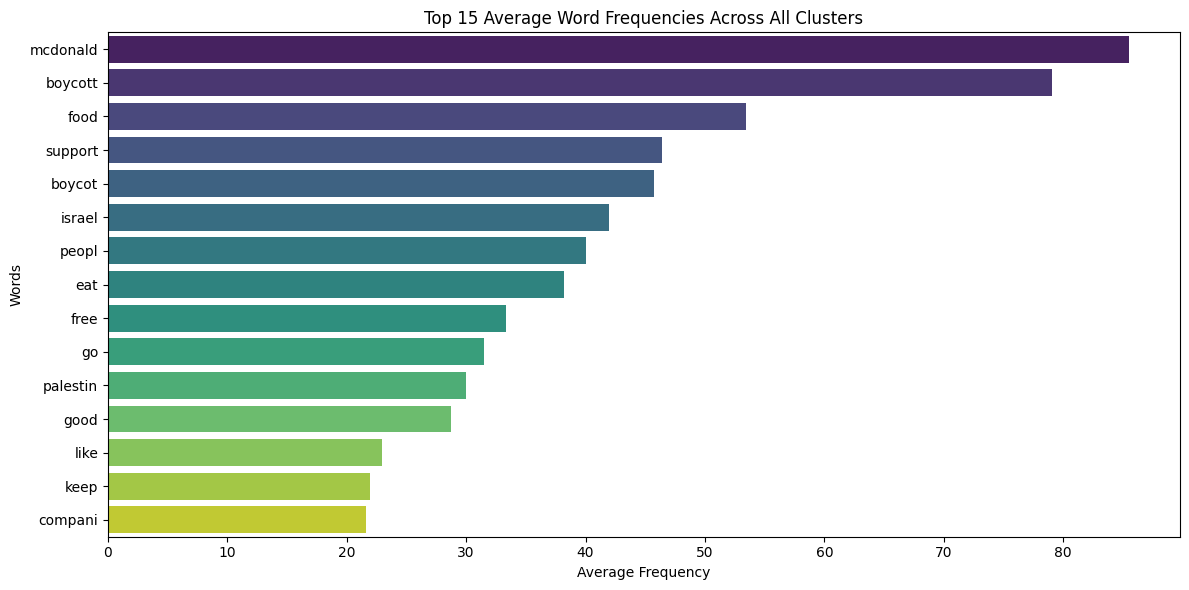

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasikan rata-rata frekuensi kata
plt.figure(figsize=(12, 6))
top_n = 15  # Jumlah kata teratas untuk ditampilkan
sns.barplot(
    x=global_word_averages['Frequency'].head(top_n), 
    y=global_word_averages['Word'].head(top_n), 
    palette='viridis'
)
plt.title('Top 15 Average Word Frequencies Across All Clusters')
plt.xlabel('Average Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()


C:\Users\Ryan\AppData\Local\Temp\ipykernel_10280\2406218934.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


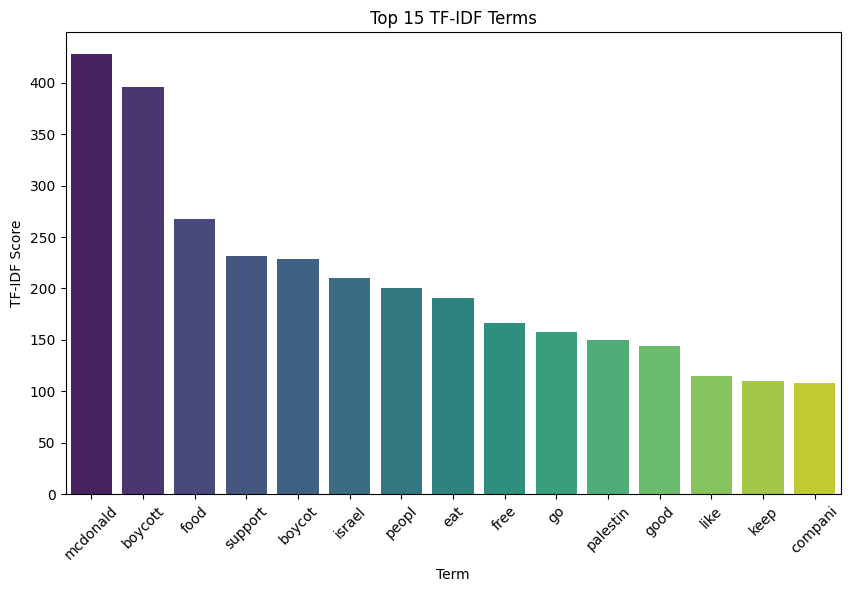

In [21]:
## Visualizing TF-IDF Terms (Bar Chart)
feature_array = vectorizer.get_feature_names_out()
tfidf_sorting = X.toarray().sum(axis=0).argsort()[::-1]
top_n = 15

plt.figure(figsize=(10, 6))
sns.barplot(
    x=[feature_array[i] for i in tfidf_sorting[:top_n]],
    y=[X.toarray().sum(axis=0)[i] for i in tfidf_sorting[:top_n]],
    palette='viridis'
)
plt.xticks(rotation=45)
plt.title('Top 15 TF-IDF Terms')
plt.xlabel('Term')
plt.ylabel('TF-IDF Score')
plt.show()

In [22]:
# Simpan hasil rata-rata ke file CSV
global_word_averages.to_excel('global_average_word_frequencies.xlsx', index=False)
print("Saved global average word frequencies to 'global_average_word_frequencies.xlsx'.")

Saved global average word frequencies to 'global_average_word_frequencies.xlsx'.


In [ ]:
# Simpan hasil rata-rata ke file CSV
global_word_averages.to_csv('global_average_word_frequencies.csv', index=False)
print("Saved global average word frequencies to 'global_average_word_frequencies.csv'.")

In [ ]:
for cluster, table in wordcloud_tables.items():
    table.to_excel(f'cluster_{cluster}_wordcloud_table.csv', index=False)
print("WordCloud tables saved as CSV files.")

WordCloud tables saved as CSV files.


In [ ]:
for cluster, table in wordcloud_tables.items():
    table.to_excel(f'cluster_{cluster}_wordcloud_table.xlsx', index=False)
print("WordCloud tables saved as CSV files.")

In [ ]:
## Save Results to CSV
data.to_csv('youtube_comments_analysis.csv', index=False)

print("Analysis complete. Results saved to 'youtube_comments_analysis.csv'.")


Analysis complete. Results saved to 'youtube_comments_analysis.xlsx'.


In [ ]:
## Save Results to CSV
data.to_excel('youtube_comments_analysis.xlsx', index=False)

print("Analysis complete. Results saved to 'youtube_comments_analysis.xlsx'.")
